# ECSE 415 - Final Project

In this project, we are interested in analyzing dashcam footage from cars. Specifically, we are interersted in counting the number of parked cars, moving cars, and pedestrians that were passed.

Though relatively simple, this project implements some of the basic functionalities that could be found in self-driving cars, and provides us with additional insights into the world of computer vision.

In this notebook we will be going over the approach we took to solve the problem, explanations of relevant code sections, results, performance analysis, and comparison with ground truth. Additionally, we discuss the problems we encountered with our solution, and potential future works to improve the software.

## Setup

We start by importing the relevant libraries
- numpy (v1.23.3)
- matplotlib (v3.5.1)
- cv2 (v4.8.1.78)
- scikit-learn (v1.1.3)
- pickle (included with python interpreter)

Additionally, we import some types for type-hinting purposes.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from sklearn.cluster import MeanShift, estimate_bandwidth

# Type hinting
from typing import Generator
from cv2.typing import MatLike

/home/joseph/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Next, we define a `PATH` variable that points to the repository. Every memory access in the code will be relative to that variable.

We also define a few functions that will be useful throughout the code:
- `showImages`: This function displays a grid of images with their titles.
- `showGSImages`: This function displays a grid of grayscale images with their titles.

In [4]:
PATH = "./"

np.set_printoptions(edgeitems=24)

def showImages(images: list[list[MatLike]], titles: list[list[str]]):
    """
    This function takes a 2D array of images and titles and displays them in the notebook in color.

    ---

    Parameters
    ----------
    `images`: `list[list[MatLike]]`
        2D grid of images to be displayed.
    
    `titles`: `list[list[str]]`
        2D grid of titles that correspond to each image. It must have the same shape as the `images`
        grid.
    """
    
    rows = len(images)
    cols = len(images[0])
    fig = plt.figure(figsize=(cols * 7 if cols > 1 else 12, rows * 5))

    # Add every picture in the plot
    for i in range(rows):
        for j in range(cols):
            if images[i][j] is None: continue
            fig.add_subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i][j][:,:,::-1])
            plt.axis('off')
            plt.title(titles[i][j])
    
    plt.show()


def showGSImages(images, titles, cmap=[]):
    """
    This function takes a 2D array of grayscale images and titles and displays them in the notebook.

    ---

    Parameters
    ----------
    `images`: `list[list[MatLike]]`
        2D grid of grayscale images to be displayed.
    
    `titles`: `list[list[str]]`
        2D grid of titles that correspond to each image. It must have the same shape as the `images`
        grid.
    """

    rows = len(images)
    cols = len(images[0])
    fig = plt.figure(figsize=(cols * 7 if cols > 1 else 12, rows * 5))

    # Add every picture in the plot
    for i in range(rows):
        for j in range(cols):
            if images[i][j] is None: continue
            fig.add_subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i][j], cmap=cmap[i][j] if len(cmap) != 0 else 'gray')
            plt.axis('off')
            plt.title(titles[i][j])
    
    plt.show()


# 1 Video Reader

We define a `VideoReader` class that helps with reading video from the filesystem.

It is based on OpenCV's `VideoCapture` class, and helps with reading the frames of a video, as well as getting information such as the frame dimension and the FPS value.

The main purpose of this class is to wrap the functionalities needed to read every nth frame of a video using the `VideoReader.frames(n)` function.

In [5]:
class VideoReader():
    """
    A class used to read videos from the filesystem.
    
    ---

    Attributes
    ----------
    `filename` : `str`
        A string pointing to the path of the video in the file system.
    
    `cap` : `VideoCapture`
        The underlying OpenCV `VideoCapture` that helps read the video file.

    `framewidth` : `int`
        An integer indicating the width of the frames in the video.

    `frameheight` : `int`
        An integer indicating the height of the frames in the video.
    
    `fps` : `float`
        A floating-point number indicating the framerate of the video.

    ---

    Methods
    -------
    `getInfo() -> (int, int, float)`
        Get basic information about the video: frame width, frame height, frame rate.

    `frames(freq: int) -> Generator[MatLike, None, None]`
        Generator function that yields every nth frame.

    `release()`
        Video capture release.
    """
    
    def __init__(self, filename: str):
        # Open video
        self.cap = cv2.VideoCapture(filename)

        # Ensure video was correctly opened or raise exception
        if(self.cap.isOpened() == False):
            raise SystemExit("Error opening video file!")
        
        # Get basic information of video
        self.frame_width = int(self.cap.get(3))
        self.frame_height = int(self.cap.get(4))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
    
    
    def getInfo(self) -> (int, int, float):
        """
        Get basic information about the video: frame width, frame height, frame rate.

        ---

        Returns
        -------
        `int`
            Frame width

        `int`
            Frame height
            
        `float`
            Frame rate
        """
        return self.frame_width, self.frame_height, self.fps
    

    def frames(self, freq: int) -> Generator[MatLike, None, None]:
        """
        Generator function that yields every nth frame of the video.

        ---

        Parameters
        ----------
        `freq`: `int`
            Integer representing the number of frames to skip before yielding the next one.
        
        ---

        Yields
        ------
        `MatLike`
            Next frame of the video.
        """
        i = 0
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            
            # If end of video is reached, exit the generator loop
            if ret == False: break

            i += 1
            # Skip frame if its index is not a multiple of freq
            if i % freq != 0: continue

            yield frame
    
    
    def release(self):
        """
        Function that releases the `VideoCapture` element that helped read the video.
        """
        self.cap.release()

In [6]:
class BoundingBox():
    """
    A class that is used to represent a bounding box detected by object detector models.

    ---

    Attributes
    ----------
    `x`: `float`
        Float representing the x-coordinate of the top-left corner of the bounding box.
    
    `y`: `float`
        Float representing the y-coordinate of the top-left corner of the bounding box.
    
    `w`: `float`
        Float representing the width of the bounding box.
    
    `h`: `float`
        Float representing the height of the bounding box.
    
    `clazz`: `int`
        Class ID of the detected object.
    
    `confidence`: `float`
        Float between 0 and 1 representing the classification confidence of the object in the
        bounding box.
    
    `center_x`: `float`
        Float representing the x-coordinate of the center point of the bounding box.
    
    `center_y`: `float`
        Float representing the y-coordinate of the center point of the bounding box.
    
    ---

    Methods
    -------
    `get_distance(other: BoundingBox)`
        This function computes the distance between the center point of this bounding box and the
        center point of another bounding box.
    
    `get_top_left_corner() -> (int, int)`
        This function returns a tuple holding the rounded coordinates of the top-left corner of the
        bounding box.
    
    `get_lower_right_corner() -> (int, int)`
        This function returns a tuple holding the rounded coordinates of the lower-right corner of
        the bounding box.
    """
    
    def __init__(self, x: float, y: float, w: float, h: float, clazz: int, confidence: float):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.clazz = clazz
        self.confidence = confidence

        # Compute center coordinates of the bounding box
        self.center_x = x + w / 2
        self.center_y = y + h / 2
    

    def get_distance(self, other: "BoundingBox") -> float:
        """
        This function computes the distance between the center point of this bounding box and the
        center point of another bounding box.

        ---

        Parameters
        ----------
        `other`: `BoundingBox`
            The other bounding box with which to compute the distance.
        
        ---

        Returns
        -------
        `float`
            Distance between this bounding box and the other.
        """
        return np.sqrt((self.center_x - other.center_x) ** 2 + (self.center_y - other.center_y) ** 2)


    def get_top_left_corner(self) -> (int, int):
        """
        This function returns a tuple holding the rounded coordinates of the top-left corner of the
        bounding box.

        ---

        Returns
        -------
        `(int, int)`
            Tuple of the rounded coordinates (x, y) of the top-left corner of the bounding box.
        """
        return (round(self.x), round(self.y))
    

    def get_lower_right_corner(self) -> (int, int):
        """
        This function returns a tuple holding the rounded coordinates of the lower-right corner of 
        the bounding box.

        ---

        Returns
        -------
        `(int, int)`
            Tuple of the rounded coordinates (x, y) of the lower-right corner of the bounding box.
        """
        return (round(self.x + self.w), round(self.y + self.h))

In [7]:
class Object():
    """
    A class that represents an object in the video.

    ---

    Attributes
    ----------
    `id`: `int`
        Unique ID of the object in the video.
    
    `bounding_box`: `BoundingBox`
        The bounding box of the object in the video. This is updated every frame.
    
    `absent_frames`: `int`
        The number of frames since the object disappeared from the scene.

    `distance_from_origin`: `float`
        The distance of the object from the frame center.
    """

    def __init__(self, id: int, bounding_box: BoundingBox):
        self.id = id
        self.bounding_box = bounding_box
        self.distance_from_origin = np.sqrt((self.bounding_box.center_x - 2562/2) ** 2 + (self.bounding_box.center_y - 1440/2) ** 2)
        self.absent_frames = 0

    def __str__(self) -> str:
        return f"#{self.id} ({self.bounding_box.center_x}, {self.bounding_box.center_y})"


In [8]:
class Yolo:
    """
    A class that contains a YOLOv3 model pretrained on the COCO dataset.
    It wraps the functionalities to process a picture on this model and retrieve the bounding boxes
    of the detected and classified objects.

    ---

    Attributes
    ----------
    `yolov3`: `Net`
        YOLOv3 neural network pretrained on the COCO dataset.

    `classes`: `list[str]`
        List of classes that can be classified by the model.
    
    `colors`: `ndarray[Any, dtype[float64]]`
        Randomly-generated RGB tuples list where each tuple represents the color associated to a
        class. For the purposes of drawing the bounding boxes.
    
    ---

    Methods
    -------
    `process_frame(frame: MatLike) -> list[BoundingBox]`
        This function processes an image using the model and returns a list of the resulting
        bounding boxes.
    
    `draw_bounding_box(img: MatLike, obj: Object)`
        This function draws a given object and its associated bounding box on a given image.
    """
    
    def __init__(self):
        # Import Darknet Yolov3 CNN from file as well as weights from COCO pretraining
        self.yolov3 = cv2.dnn.readNet(PATH + "/data/yolov3.weights", PATH + "/data/yolov3.cfg")

        # Import COCO classes from file
        self.classes = []
        classes_file = open(PATH + "/data/yolov3.classes", "r")
        for l in classes_file.readlines():
            self.classes.append(l.strip())

        # Generate random colors for each class to draw bounding boxes
        self.colors = np.random.uniform(0, 255, size=(len(self.classes), 3))
    
    
    def process_frame(self, frame: MatLike) -> list[BoundingBox]:
        """
        This function processes an image using the model and returns a list of the resulting
        bounding boxes.

        ---

        Parameters
        ----------
        `frame`: `MatLike`
            Image to be processed by the model.
        
        ---

        Returns
        -------
        `list[BoundingBox]`
            The list of bounding boxes found by the model.
        """
        frame_blob = cv2.dnn.blobFromImage(frame, 0.00392, (416,416), (0,0,0), True, crop=False)

        # Execute neural network with image as input
        self.yolov3.setInput(frame_blob)
        output = self.yolov3.forward()

        class_ids = []
        confidences = []
        boxes = []

        CONF_THRESH = 0.5
        # Extract data from output matrix
        for o in output:
            # Get predicted class and confidence for bounding box
            scores = o[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            # Consider bounding box only if confidence is above threshold value
            if confidence > CONF_THRESH:
                center_x = int(o[0] * frame.shape[1])
                center_y = int(o[1] * frame.shape[0])
                w = int(o[2] * frame.shape[1])
                h = int(o[3] * frame.shape[0])
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

        # Apply non-max suppression
        NMS_THRESH = 0.4
        indices = cv2.dnn.NMSBoxes(boxes, confidences, CONF_THRESH, NMS_THRESH)

        # Create the bounding box objects
        bounding_boxes = []
        for idx in indices:
            bounding_boxes.append(BoundingBox(boxes[idx][0], boxes[idx][1], boxes[idx][2], boxes[idx][3], class_ids[idx], confidences[idx]))

        return bounding_boxes


    # function to draw bounding box on the detected object with class name
    def draw_bounding_box(self, img: MatLike, obj: Object):
        """
        This function draws a given object and its associated bounding box on a given image.

        ---

        Parameters
        ----------
        `img`: `MatLike`
            Image on which to draw the object and its bounding box.
        
        `obj`: `Object`
            Object to draw on the image.
        """
        label = "{} {} (#{})".format(self.classes[obj.bounding_box.clazz], round(obj.bounding_box.confidence, 2), obj.id)
        color = self.colors[obj.bounding_box.clazz]
        cv2.rectangle(img, obj.bounding_box.get_top_left_corner(), obj.bounding_box.get_lower_right_corner(), color, 2)
        cv2.putText(img, label, (round(obj.bounding_box.x - 10), round(obj.bounding_box.y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

In [9]:
DISTANCE_THRESHOLD = 75
MAX_ABSENT_FRAMES = 5

class Objects():
    """
    A class that contains the objects present in the scene and the necessary logic to track objects
    across frames.

    ---

    Attributes
    ----------
    `idx`: `int`
        Integer iterator that tracks the next unique ID that can be given to a new object.
    
    `objects`: `dict[int, list[Object]]`
        Dictionary contianing lists of objects categorized by their class.
    
    ---

    Methods
    -------
    `add_frame(bbs: list[BoundingBox])`
        This function takes in the bounding boxes of the next frame and matches the existing objects
        to the new bounding boxes. It updates the the matched objects, creates new objects for new
        bounding boxes, and removes objects that no longer exist, when appropriate.
    
    `compute_distances(clazz: int, bbs: list[BoundingBox]) -> dict[tulpe[Object, BoundingBox], float]`
        This function computes all the distances between the objects in the class's dictionary that
        correspond to the input class ID, and the input bounding boxes.
    
    `match_bounding_boxes(distances: dict[tuple[Object, BoundingBox], float]) -> (list[tuple[Object, BoundingBox]], list[Object], list[BoundingBox])`
        This function finds the matches between the existing objects in the scene and the input
        bounding boxes.
    
    `next_id() -> int`
        This function increments `idx` and returns the new value. This serves when creating a new
        object.
    
    `get_all_objects() -> list[Object]`
        This function returns a list of all objects in the scene by flattening the dictionary
        values.
    """

    def __init__(self):
        self.idx = -1
        self.objects: dict[int, list[Object]] = dict({})


    def add_frame(self, bbs: list[BoundingBox]):
        """
        This function takes in the bounding boxes of the next frame and matches the existing objects
        to the new bounding boxes. It updates the the matched objects, creates new objects for new
        bounding boxes, and removes objects that no longer exist, when appropriate.

        ---

        Parameters
        ----------
        `bbs`: `list[BoundingBox]`
            The new bounding boxes found in the next frame.
        """
        # For each objects of a given class
        for c in self.objects.keys():
            # Find the matches with the new bounding boxes
            bbs_c = list(filter(lambda bb: bb.clazz == c, bbs))
            distances = self.compute_distances(c, bbs_c)
            matches, used_objs, used_bbs = self.match_bounding_boxes(distances)

            # Eliminate matches that excees the distance threshold
            for match in matches:
                if distances[match] > (match[0].absent_frames + 1) * DISTANCE_THRESHOLD:  # multiply by sizes
                    used_objs.remove(match[0])
                    used_bbs.remove(match[1])
                    matches.remove(match)

            # Increment the absent_frames attribute of all objects that do not appear in the new
            # frame
            for obj in self.objects[c]:
                if not obj in used_objs:
                    obj.absent_frames += 1

                    if obj.absent_frames > MAX_ABSENT_FRAMES:
                        self.objects[c].remove(obj)
            
            # Create a new object for every bounding box that was not present in the previous frames
            for bb in bbs_c:
                if not bb in used_bbs:
                    self.objects[c].append(Object(self.next_id(), bb))

            # Update the bounding boxes of the matched objects
            for match in matches:
                match[0].bounding_box = match[1]
                match[0].absent_frames = 0
        
        # For every bounding box whose class was not previously present in the dictionary:
        # 1. Add a new list entry to the dictionary
        # 2. Create a new object for the bounding box
        # 3. Append the new object to the dictionary
        for bb in list(filter(lambda bb: (not bb.clazz in self.objects), bbs)):
            if bb.clazz not in self.objects: self.objects[bb.clazz] = []
            self.objects[bb.clazz].append(Object(self.next_id(), bb))


    def compute_distances(self, clazz: int, bbs: list[BoundingBox]) -> dict[tuple[Object, BoundingBox], float]:
        """
        This function computes all the distances between the objects in the class's dictionary that
        correspond to the input class ID, and the input bounding boxes.

        ---

        Parameters
        ----------
        `clazz`: `int`
            Class ID whose objects to get from the class's dictionary.
        
        `bbs`: `list[BoundingBox]`
            Bounding boxes to compute the distances with. These should also be of the class `clazz`.
        
        ---

        Returns
        -------
        `dict[tuple[Object, BoundingBox], float]
            Dictionary mapping each object-bounding box pair to the distance that separates them.
        """
        distances: dict[tuple[Object, BoundingBox], float] = dict({})

        # Compute distances between all objects and all bounding boxes
        for obj in self.objects[clazz]:
            for bb in bbs:
                distances[(obj, bb)] = obj.bounding_box.get_distance(bb)

        return distances


    def match_bounding_boxes(self, distances: dict[tuple[Object, BoundingBox], float]) -> (list[tuple[Object, BoundingBox]], list[Object], list[BoundingBox]):
        """
        This function finds the matches between the existing objects in the scene and the input
        bounding boxes.

        ---

        Parameters
        ----------
        `distances`: `dict[tuple[Object, BoundingBox], float]`
            Dictionary mapping each object-bounding box pair to the distance that separates them.
        
        ---

        Returns
        -------
        `list[tuple[Object, BoundingBox]]`
            List of object-bounding box pairs representing the matches. Each object and bounding box
            appears only once in the list.
        
        `list[Object]`
            List of matched objects.

        `list[BoundingBox]`
            List of matched bounding boxes.
        """
        # Sort the distances dictionary
        sorted_keys = list(sorted(distances, key=distances.get))

        mutex_keys = []
        used_objs = set([])
        used_bbs = set([])
        for k in sorted_keys:
            # If object or bounding box is already match, skip entry
            if k[0] in used_objs or k[1] in used_bbs: continue

            # Mark the matched object and bounding box as used
            used_objs.add(k[0])
            used_bbs.add(k[1])

            # Append the pair to the list of matches
            mutex_keys.append(k)

        return mutex_keys, used_objs, used_bbs


    def next_id(self) -> int:
        """
        This function increments `idx` and returns the new value. This serves when creating a new
        object.

        ---

        Returns
        -------
        `int`
            The unique ID to use for the new object.
        """
        self.idx += 1
        return self.idx
    

    def get_all_objects(self) -> list[Object]:
        """
        This function returns a list of all objects in the scene by flattening the dictionary
        values.

        ---

        Returns
        -------
        `list[Object]`
            The list of all objects in the scene.
        """
        return  [value for sublist in self.objects.values() for value in sublist]
    

    def copy(self):
        """
        This function returns a copy of the current `Objects` instance.

        ---

        Returns
        -------
        `Objects`
            A copy of the current `Objects` instance.
        """
        new_objects = Objects()
        new_objects.idx = self.idx
        new_objects.objects = {
            key: [Object(obj.id, obj.bounding_box) for obj in value]
            for key, value in self.objects.items()
        }

        return new_objects
    
    def __str__(self):
        return str(list(tuple([key, [str(obj) for obj in value]]) for key, value in self.objects.items())) + "\n"


In [10]:
def apply_YOLO_with_tracking(video_name: str):
    """
    This function applies the YOLOv3 model to a video and saves the output video with the bounding.
    While doing so, it also tracks the objects in the scene and assigns them unique IDs.
    The function also saves the list of objects per frame to a file.

    ---
    Attributes

    `video_name`: `str`
        The name of the video file to process.
    """
    # Create an instance of the model
    yolo = Yolo()

    # Create the video reader
    video_in = VideoReader(PATH + "/data/" + video_name)
    # Get basic information on video and print them
    frame_width, frame_height, fps = video_in.getInfo()
    print("Frame dimensions: ({}, {})".format(frame_width, frame_height))
    print("FPS: {}".format(fps))

    # Create the output video stream
    out = cv2.VideoWriter(PATH + "/out/" + video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))

    # Create the object that holds all objects in the scene
    objects = Objects()

    # Create a list of objects per frame
    frames_objects_dict : list[Objects] = []

    # Loop over every frame
    for frame_i in video_in.frames(1):
        # Process frame and process new bounding boxes for tracking
        bounding_boxes = yolo.process_frame(frame_i)
        objects.add_frame(bounding_boxes)

        frames_objects_dict.append(objects.copy())

        # Draw each object on the frame picture
        for obj in objects.get_all_objects():
            yolo.draw_bounding_box(frame_i, obj)

        # Write the new frame picture with bounding boxes to the output video
        out.write(frame_i)

    # save objects_per_frame list to file
    with open(PATH + "/out/objects_" + video_name.split('.')[0] + ".bb", "wb") as f:
        pickle.dump(frames_objects_dict, f)


    # Release video streams
    video_in.release()
    out.release()

In [11]:
# Apply YOLOv2 and tracking to both videos
video_names = (
    "mcgill_drive.mp4",
    "st-catherines_drive.mp4"
)

In [12]:
for video_name in video_names:
    apply_YOLO_with_tracking(video_name)  # very long, takes 10 minutes

Frame dimensions: (2562, 1440)
FPS: 29.97002997002997


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/joseph/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14125/1098637182.py", line 2, in <module>
    apply_YOLO_with_tracking(video_name)  # very long, takes 10 minutes
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14125/2729888707.py", line 35, in apply_YOLO_with_tracking
    bounding_boxes = yolo.process_frame(frame_i)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14125/3628335478.py", line -1, in process_frame
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/joseph/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/joseph/.

In [13]:
# read objects_per_frame list from file
def retrieve_objects_for_video(video_name: str) -> list[Objects]:
    """
    This function reads the list of objects per frame from a file.

    ---

    Attributes

    `video_name`: `str`
        The name of the video file to process.

    ---

    Returns
    -------
    `list[Objects]`
        The list of objects per frame.
    """
    with open(PATH + "/out/objects_" + video_name.split('.')[0] + ".bb", "rb") as f:
        frames_objects_dict: list[Objects] = pickle.load(f)

    print("Number of frames: {}".format(len(frames_objects_dict)))

    return frames_objects_dict


# Create a dictionary mapping video names to the list of objects per frame
video_frames_objects_dict : dict[str: list[Objects]] = {
    video_name: retrieve_objects_for_video(video_name)
    for video_name in video_names
}

Number of frames: 1071
Number of frames: 1477


In [49]:
CARS_CLASS_ID = 2
PEDESTRIANS_CLASS_ID = 0

class ObjectTracker():
    """
    A class that tracks the position of an object across frames.

    ---

    Attributes
    ----------
    `clazz`: `int`
        The class ID of the object.

    `frames_pos_dict`: `dict[int, tuple[int, int, float]]`
        Dictionary mapping frame indices to tuples of the object's position and position from frame origin.

    `displacement`: `float`
        The displacement of the object across frames.
    ---
    """


    def __init__(self, clazz: int, frames_pos_dict: dict[int, tuple[int, int, float]]) -> None:
        self.clazz: int = clazz
        self.frames_pos_dict: dict[int, tuple[int, int]] = frames_pos_dict
        self.displacement: float = -1


    def compute_displacement(self):
        """
        This function computes the displacement of the object across frames.
        """
        if len(self.frames_pos_dict) < 2:
            self.displacement = 0
            return

        self.displacement = 0
        prev_pos = None
        for frame, pos in self.frames_pos_dict.items():
            if prev_pos is None:
                prev_pos = pos
                continue

            self.displacement += np.sqrt((pos[0] - prev_pos[0]) ** 2 + (pos[1] - prev_pos[1]) ** 2) / (pos[2])**0.5
            prev_pos = pos

        self.displacement /= max(self.frames_pos_dict.keys()) - min(self.frames_pos_dict.keys())  # calculate mean (divide sum by number of frames)

        # normalize displacement to [0, 100]


    def __str__(self) -> str:
        return str(self.frames_pos_dict)


def compute_video_objects_displacement(frames_objects_dict: list[Objects]) -> dict[int, ObjectTracker]:
    """
    This function computes the displacement of the objects in the scene across frames.

    ---
    Attributes

    `frames_objects_dict`: `list[Objects]`
        The list of objects per frame.

    ---

    Returns

    `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.

    """
    # create a dictionary of objects position across frames
    objects_position : dict[int, ObjectTracker] = dict({})

    for frame_i, objects in enumerate(frames_objects_dict):
        for obj in objects.get_all_objects():
            if obj.id not in objects_position:
                objects_position[obj.id] = ObjectTracker(obj.bounding_box.clazz, dict({}))
            objects_position[obj.id].frames_pos_dict[frame_i] = (obj.bounding_box.center_x, obj.bounding_box.center_y, obj.distance_from_origin)

    for id, tracker in objects_position.items():
        tracker.compute_displacement()

    # drop objects with less than 20 frames tracked
    return {
        id: tracker for id, tracker in objects_position.items() if len(tracker.frames_pos_dict) > 20
    }


def apply_meanshift_clustering(video_name: str, objects_position: dict[int, ObjectTracker]):
    """
    This function applies the MeanShift clustering algorithm to the objects in the scene.
    Also plots the displacements of the objects and prints the IDs of the objects as well as the regions.

    ---

    Attributes
    ----------

    `video_name`: `str`
        The name of the video file to process.

    `objects_position`: `dict[int, ObjectTracker]`
        Dictionary mapping object IDs to their `ObjectTracker` instances.
    """
    car_trackers_displacement = [tracker.displacement for tracker in objects_position.values() if tracker.clazz == CARS_CLASS_ID]

    # plot horizontal lines on the scatter representing the cluster centers
    plt.figure(figsize=(12, 8))
    plt.title(f"Average speed of cars of video '{video_name}'")
    plt.ylabel("Average Speed")
    plt.xticks([])

    plt.scatter(x=list(range(len(car_trackers_displacement))),y=car_trackers_displacement)

    # draw the ids of the objects
    i = 0
    for id, tracker in objects_position.items():
        if tracker.clazz == CARS_CLASS_ID:
            plt.annotate(id, (i, tracker.displacement))
            i += 1

    # use 1D meanshift to cluster the displacements
    X = np.array(car_trackers_displacement).reshape(-1, 1)
    bandwidth = estimate_bandwidth(X, quantile=0.5)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    cluster_centers = sorted(ms.cluster_centers_)

    print("Cluster Centers:")
    print(cluster_centers)

    for i, line in enumerate(cluster_centers):
        plt.axhline(y=line, color='r', linestyle='-')
        conclusion = ""
        ycord = 0
        if i == 0:
            conclusion = "NOT PASSED"
            ycord = cluster_centers[0]/2
        if i == 1:
            conclusion = "PASSED PARKED"
            ycord = (cluster_centers[1] - cluster_centers[0]) / 2 + cluster_centers[0]
        if i == 2:
            conclusion = "PASSED MOVING"
            ycord = (cluster_centers[2] - cluster_centers[1]) / 2 + cluster_centers[1]

        plt.annotate(conclusion, (-1, ycord), color='r', size=9,
                     weight='bold', ha='center', va='center', rotation=90)


    plt.show()

    for id, tracker in objects_position.items():
        if tracker.clazz == 2:
            car_info = f"displ={tracker.displacement}\tn_frames={len(tracker.frames_pos_dict.keys())}\tfirst_frame={min(tracker.frames_pos_dict.keys())}\t last_frame={max(tracker.frames_pos_dict.keys())}"
            if cluster_centers[1] > tracker.displacement > cluster_centers[0]:
                print(f"Parked #{id} {car_info}")
            elif tracker.displacement > cluster_centers[1]:
                print(f"Moving #{id} {car_info}")



Cluster Centers:
[array([0.14489237]), array([0.31091766]), array([0.7623873])]


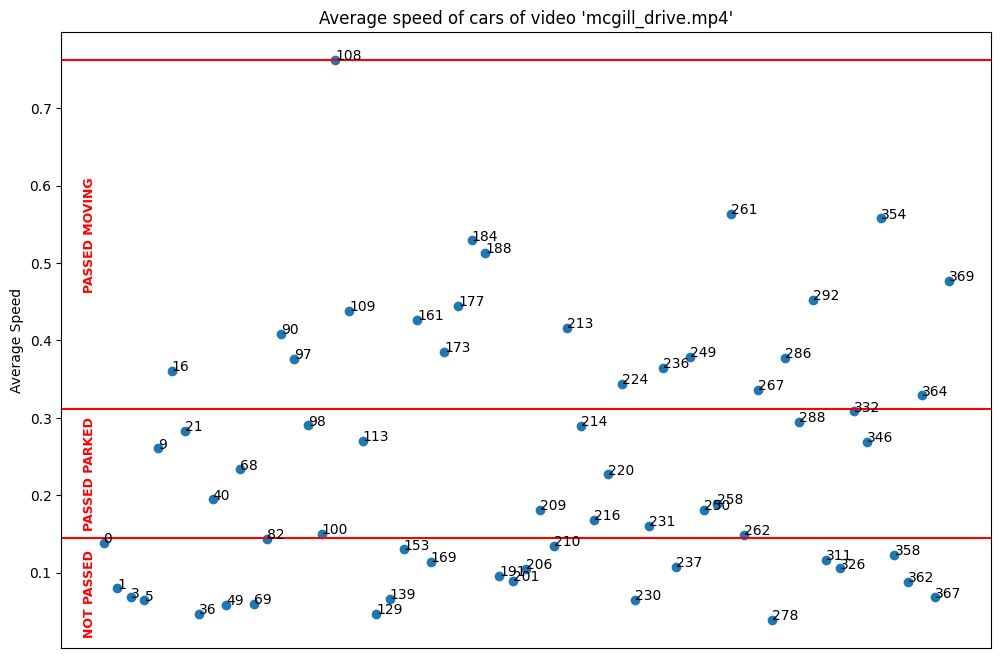

Parked #9 displ=0.2604058119808384	n_frames=132	first_frame=6	 last_frame=137
Moving #16 displ=0.36103380038289706	n_frames=107	first_frame=39	 last_frame=145
Parked #21 displ=0.2832229143224198	n_frames=105	first_frame=81	 last_frame=185
Parked #40 displ=0.1947297658343901	n_frames=77	first_frame=123	 last_frame=199
Parked #68 displ=0.23331913184328962	n_frames=110	first_frame=193	 last_frame=302
Moving #90 displ=0.40844950740977365	n_frames=61	first_frame=249	 last_frame=309
Moving #97 displ=0.37583338082702306	n_frames=48	first_frame=291	 last_frame=338
Parked #98 displ=0.29021530280777663	n_frames=133	first_frame=300	 last_frame=432
Parked #100 displ=0.14992180891269297	n_frames=44	first_frame=302	 last_frame=345
Moving #108 displ=0.7623872963815526	n_frames=21	first_frame=334	 last_frame=354
Moving #109 displ=0.4379420697040681	n_frames=33	first_frame=336	 last_frame=368
Parked #113 displ=0.27054162300056894	n_frames=46	first_frame=361	 last_frame=406
Moving #161 displ=0.426670090

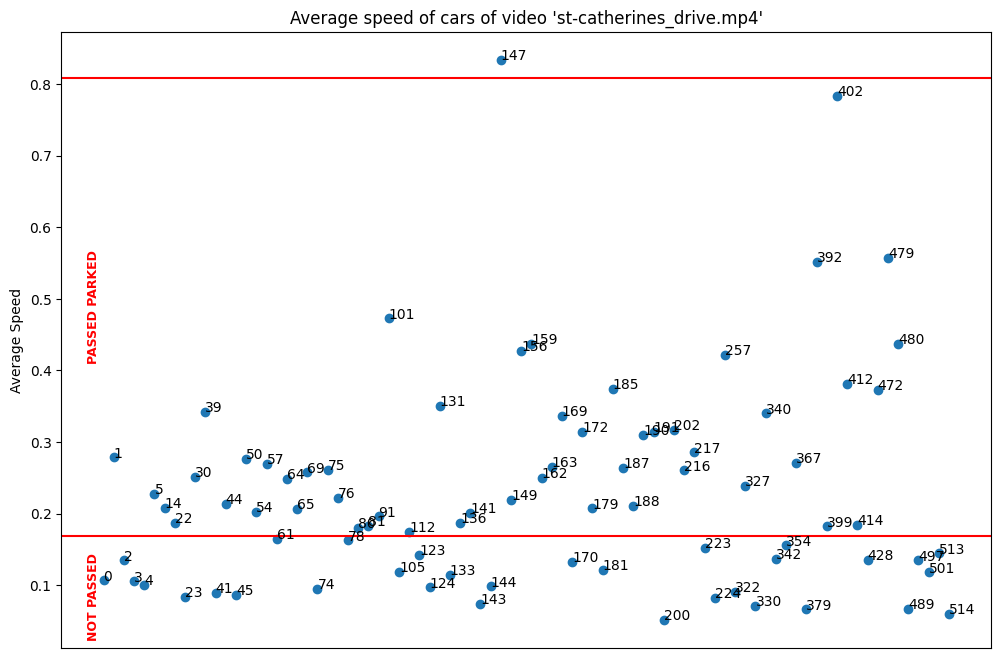

Parked #1 displ=0.2786350891247448	n_frames=26	first_frame=0	 last_frame=25
Parked #5 displ=0.22802370477725217	n_frames=46	first_frame=0	 last_frame=45
Parked #14 displ=0.20819109431473115	n_frames=68	first_frame=19	 last_frame=86
Parked #22 displ=0.18742541711943772	n_frames=94	first_frame=57	 last_frame=150
Parked #30 displ=0.25109780202922927	n_frames=65	first_frame=78	 last_frame=142
Parked #39 displ=0.34248777482639575	n_frames=125	first_frame=104	 last_frame=228
Parked #44 displ=0.2131957286252164	n_frames=281	first_frame=117	 last_frame=397
Parked #50 displ=0.27646513332070977	n_frames=42	first_frame=139	 last_frame=180
Parked #54 displ=0.20251159020057025	n_frames=96	first_frame=144	 last_frame=239
Parked #57 displ=0.26934724641888275	n_frames=50	first_frame=151	 last_frame=200
Parked #64 displ=0.24855880629765664	n_frames=73	first_frame=183	 last_frame=255
Parked #65 displ=0.2062895747702513	n_frames=72	first_frame=188	 last_frame=259
Parked #69 displ=0.2575902043169512	n_fra

In [50]:
# Apply MeanShift clustering to both videos

objects_ids_position_dict : dict[str, dict[int, ObjectTracker]] = {
    video_name: compute_video_objects_displacement(frames_objects_dict)
    for video_name, frames_objects_dict in video_frames_objects_dict.items()
}

for video_name, objects_position in objects_ids_position_dict.items():
    apply_meanshift_clustering(video_name, objects_position)